In [1]:
import warnings

warnings.simplefilter("ignore")

In [2]:
%%capture
import matplotlib.pyplot as plt
import numpy as np

np.seterr(all="ignore")

from threeML import *
from threeML.io.package_data import get_path_of_data_file

In [3]:
from jupyterthemes import jtplot

%matplotlib inline
jtplot.style(context="talk", fscale=1, ticks=True, grid=False)

silence_warnings()

set_threeML_style()

# Constructing plugins from TimeSeries

Many times we encounter event lists or sets of spectral histograms from which we would like to derive a single or set of plugins. For this purpose, we provide the **TimeSeriesBuilder** which provides a unified interface to time series data. Here we will demonstrate how to construct plugins from different data types.

These utilities are helpers that allow you to *reduce data to pluigns* for spectral and temporal fitting. They are not plugins themselves.

## Constructing time series objects from different data types

The **TimeSeriesBuilder** currently supports reading of the following data type:
* A generic PHAII data file
* GBM TTE/CSPEC/CTIME files
* LAT LLE files
* POLAR spectra and polarization light curves
* KONUS GRB data

<div class="alert alert-info">

**Note:** If you would like to build a time series from your own custom data, consider creating a ```TimeSeriesBuilder.from_your_data()``` class method.

</div>



### GBM Data

Building plugins from GBM is achieved in the following fashion

In [4]:
cspec_file = get_path_of_data_file("datasets/glg_cspec_n3_bn080916009_v01.pha")
tte_file = get_path_of_data_file("datasets/glg_tte_n3_bn080916009_v01.fit.gz")
gbm_rsp = get_path_of_data_file("datasets/glg_cspec_n3_bn080916009_v00.rsp2")


gbm_cspec = TimeSeriesBuilder.from_gbm_cspec_or_ctime(
    "nai3_cspec", cspec_or_ctime_file=cspec_file, rsp_file=gbm_rsp
)

gbm_tte = TimeSeriesBuilder.from_gbm_tte(
    "nai3_tte", tte_file=tte_file, rsp_file=gbm_rsp
)

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

### LAT LLE data

LAT LLE data is constructed in a similar fashion

In [5]:
lle_file = get_path_of_data_file("datasets/gll_lle_bn080916009_v10.fit")
ft2_file = get_path_of_data_file("datasets/gll_pt_bn080916009_v10.fit")
lle_rsp = get_path_of_data_file("datasets/gll_cspec_bn080916009_v10.rsp")

lat_lle = TimeSeriesBuilder.from_lat_lle(
    "lat_lle", lle_file=lle_file, ft2_file=ft2_file, rsp_file=lle_rsp
)

## Viewing Lightcurves and selecting source intervals

All time series objects share the same commands to get you to a plugin.
Let's have a look at the GBM TTE lightcurve.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


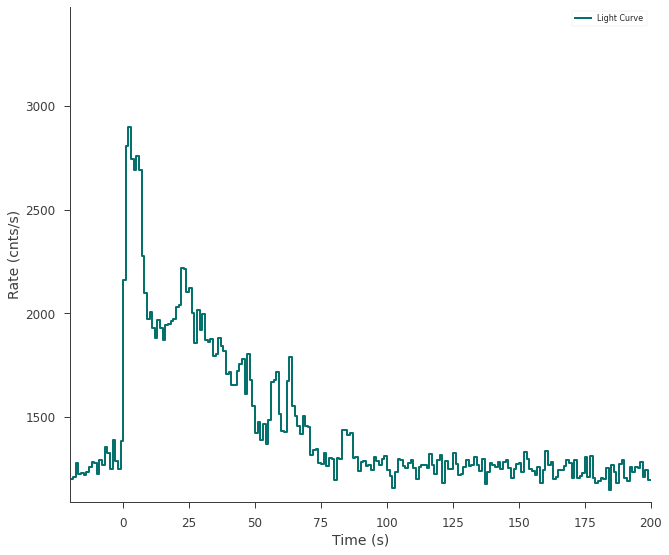

In [6]:
fig = gbm_tte.view_lightcurve(start=-20, stop=200)

Perhaps we want to fit the time interval from 0-10 seconds. We make a selection like this:

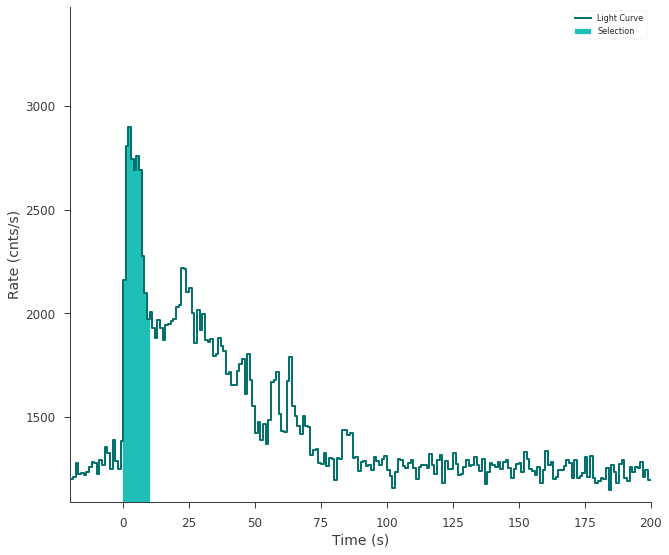

In [7]:

gbm_tte.set_active_time_interval("0-10")
fig = gbm_tte.view_lightcurve(start=-20, stop=200)

For event list style data like time tagged events, the selection is *exact*. However, pre-binned data in the form of e.g. PHAII files will have the selection automatically adjusted to the underlying temporal bins.

Several discontinuous time selections can be made.

## Fitting a polynomial background

In order to get to a plugin, we need to model and create an estimated background in each channel ($B_i$) for our interval of interest. The process that we have implemented is to fit temporal off-source regions to polynomials ($P(t;\vec{\theta})$) in time. First, a polynomial is fit to the total count rate. From this fit we determine the best polynomial order via a likelihood ratio test, unless the user supplies a polynomial order in the constructor or directly via the polynomial_order attribute. Then, this order of polynomial is fit to every channel in the data.

From the polynomial fit, the polynomial is integrated in time over the active source interval to estimate the count rate in each channel. The estimated background and background errors then stored for each channel.

$$ B_i = \int_{T_1}^{T_2}P(t;\vec{\theta}) {\rm d}t $$


Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting GBM_NAI_03 background:   0%|          | 0/128 [00:00<?, ?it/s]

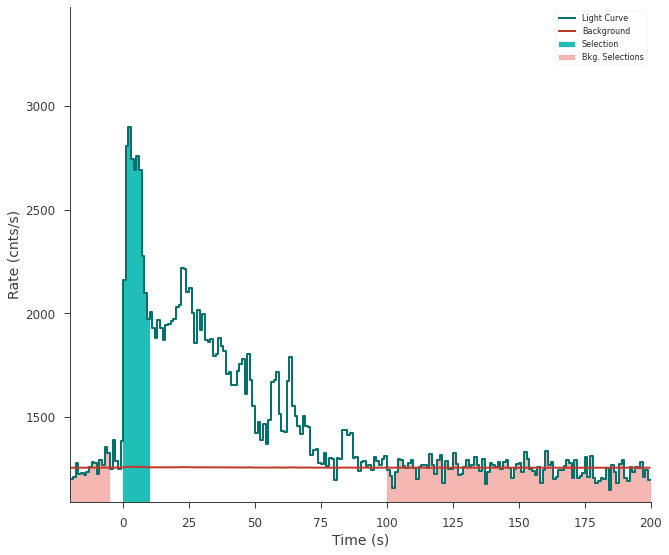

In [8]:
gbm_tte.set_background_interval("-24--5", "100-200")
fig = gbm_tte.view_lightcurve(start=-20, stop=200)

### What occurs during a fit?

In the background, the data type of the time series is analyzed (is it Poisson of Gaussian distributed?) and the time series are converted to plugins of counts / measurements vs. time. These plugins are then fit with either MLE or Bayesian methods just any other 3ML analysis. While this happens behinds the scene, it is possible to interface to these low-level operations are create your own custom background routines!

For event list data, binned or unbinned background fits are possible. For pre-binned data, only a binned fit is possible.

In [9]:
gbm_tte.set_background_interval("-24--5", "100-200", unbinned=False)

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting GBM_NAI_03 background:   0%|          | 0/128 [00:00<?, ?it/s]

## Saving the background fit

The background polynomial coefficients can be saved to disk for faster manipulation of time series data.


In [10]:
gbm_tte.save_background("background_store", overwrite=True)

In [11]:
gbm_tte_reloaded = TimeSeriesBuilder.from_gbm_tte(
    "nai3_tte",
    tte_file=tte_file,
    rsp_file=gbm_rsp,
    restore_background="background_store.h5",
)

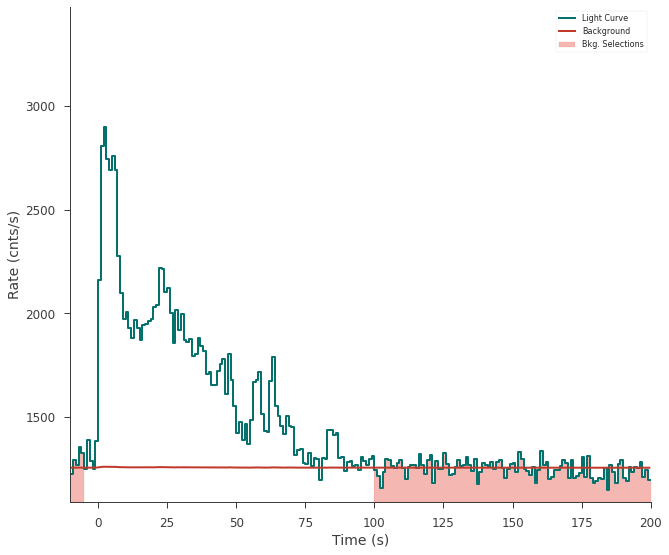

In [12]:
fig = gbm_tte_reloaded.view_lightcurve(-10, 200)

## Creating a plugin

With our background selections made, we can now create a plugin instance. In the case of GBM data, this results in a **DispersionSpectrumLike**
plugin. Please refer to the Plugins documentation for more details.

In [13]:
gbm_plugin = gbm_tte.to_spectrumlike()

In [14]:
gbm_plugin.display()

0
n. channels                     128
total rate              2508.771647
total bkg. rate         1260.975494
total bkg. rate error      3.270212
bkg. exposure               9.94112
bkg. is poisson               False
exposure                    9.94112
is poisson                     True
background                 profiled
significance              92.799636
src/bkg area ratio              1.0
src/bkg exposure ratio          1.0
src/bkg scale factor            1.0
response                       None

## Time-resolved binning and plugin creation

It is possible to temporally bin time series. There are up to four methods provided depending on the type of time series being used:

* Constant cadence (all time series)
* Custom (all time series)
* Significance (all time series)
* Bayesian Blocks (event lists)

### Constant Cadence

Constant cadence bins are defined by a start and a stop time along with a time delta.


In [15]:
gbm_tte.create_time_bins(start=0, stop=10, method="constant", dt=2.0)

In [16]:
gbm_tte.bins.display()

Start       Stop  Duration  Midpoint
0  0.000412   2.000412       2.0  1.000412
1  2.000412   4.000412       2.0  3.000412
2  4.000412   6.000412       2.0  5.000412
3  6.000412   8.000412       2.0  7.000412
4  8.000412  10.000412       2.0  9.000412

### Custom

Custom time bins can be created by providing a contiguous list of start and stop times.



In [17]:
time_edges = np.array([0.5, 0.63, 20.0, 21.0])

starts = time_edges[:-1]

stops = time_edges[1:]

gbm_tte.create_time_bins(start=starts, stop=stops, method="custom")

In [18]:
gbm_tte.bins.display()

Start   Stop  Duration  Midpoint
0   0.50   0.63      0.13     0.565
1   0.63  20.00     19.37    10.315
2  20.00  21.00      1.00    20.500

### Significance

Time bins can be created by specifying a significance of signal to background if a background fit has been performed.

In [19]:
gbm_tte.create_time_bins(start=0.0, stop=50.0, method="significance", sigma=25)

Binning by significance:   0%|          | 0/99942 [00:00<?, ?it/s]

In [20]:
gbm_tte.bins.display()

Start       Stop  Duration   Midpoint
0    0.000412   1.102108  1.101696   0.551260
1    1.102108   1.526892  0.424784   1.314500
2    1.526892   1.975848  0.448956   1.751370
3    1.975848   2.433242  0.457394   2.204545
4    2.433242   2.775556  0.342314   2.604399
5    2.775556   3.224600  0.449044   3.000078
6    3.224600   3.788502  0.563902   3.506551
7    3.788502   4.206910  0.418408   3.997706
8    4.206910   4.709384  0.502474   4.458147
9    4.709384   5.282898  0.573514   4.996141
10   5.282898   5.787524  0.504626   5.535211
11   5.787524   6.166124  0.378600   5.976824
12   6.166124   6.715524  0.549400   6.440824
13   6.715524   7.419990  0.704466   7.067757
14   7.419990   8.639396  1.219406   8.029693
15   8.639396  10.278336  1.638940   9.458866
16  10.278336  12.273390  1.995054  11.275863
17  12.273390  14.396536  2.123146  13.334963
18  14.396536  16.656876  2.260340  15.526706
19  16.656876  18.544916  1.888040  17.600896
20  18.544916  20.373686  1.828770  19.459301
21  20.373686  21.979698  1.606012  21.176692
22  21.979698  23.023478  1.043780  22.501588
23  23.023478  24.101980  1.078502  23.562729
24  24.101980  25.360608  1.258628  24.731294
25  25.360608  27.060798  1.700190  26.210703
26  27.060798  29.069756  2.008958  28.065277
27  29.069756  31.011772  1.942016  30.040764
28  31.011772  33.481182  2.469410  32.246477
29  33.481182  36.371024  2.889842  34.926103
30  36.371024  39.143378  2.772354  37.757201
31  39.143378  44.045158  4.901780  41.594268
32  44.045158  48.030536  3.985378  46.037847

### Bayesian Blocks

The Bayesian Blocks algorithm (Scargle et al. 2013) can be used to bin event list by looking for significant changes in the rate.


In [21]:
gbm_tte.create_time_bins(
    start=0.0, stop=50.0, method="bayesblocks", p0=0.01, use_background=True
)

In [22]:
gbm_tte.bins.display()

Start       Stop   Duration   Midpoint
0   0.000412   0.816854   0.816442   0.408633
1   0.816854   6.983690   6.166836   3.900272
2   6.983690   8.823971   1.840281   7.903831
3   8.823971  21.723166  12.899195  15.273569
4  21.723166  25.502056   3.778890  23.612611
5  25.502056  30.894882   5.392826  28.198469
6  30.894882  38.893854   7.998972  34.894368
7  38.893854  48.517036   9.623182  43.705445
8  48.517036  49.999594   1.482558  49.258315

### Working with bins

The light curve can be displayed by supplying the use_binner option to display the time binning


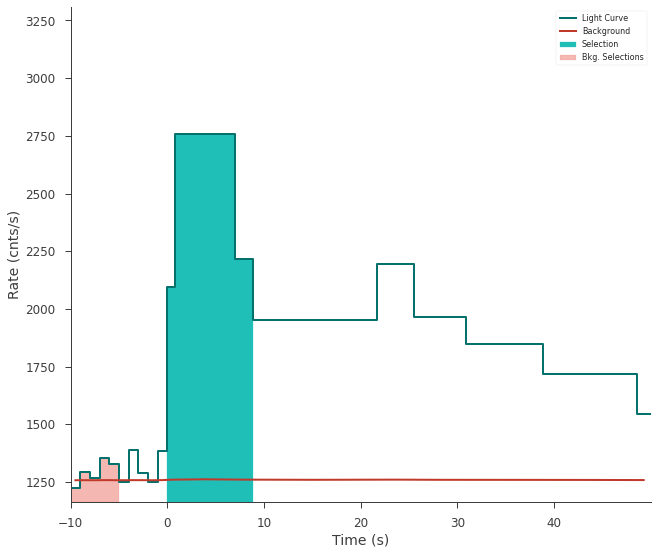

In [23]:
fig = gbm_tte.view_lightcurve(use_binner=True)

The bins can all be writted to a PHAII file for analysis via OGIPLike.

In [24]:
gbm_tte.write_pha_from_binner(
    file_name="out", overwrite=True, force_rsp_write=False
)  # if you need to write the RSP to a file. We try to choose the best option for you.

Creating plugins:   0%|          | 0/9 [00:00<?, ?it/s]

Similarly, we can create a list of plugins directly from the time series.

In [25]:
my_plugins = gbm_tte.to_spectrumlike(from_bins=True)

Creating plugins:   0%|          | 0/9 [00:00<?, ?it/s]